In [1]:
import shapefile

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

import os
from datetime import timedelta, datetime as dt
current_date = dt.now()

def closest_date(dates, date):
    dates = [
        dt.strptime(d, '%Y%m') if type(d)==str
        else d
        for d in dates]
    return min(dates, key=lambda d: abs(d - date))

def get_shp(sf_path):
    sf = shapefile.Reader(sf_path, encoding = 'Shift-JIS')

    fields = [x[0] for x in sf.fields][1:]
    records = [y[:] for y in sf.records()]
    shps = [s.points for s in sf.shapes()]

    sf_df = pd.DataFrame(columns = fields, data = records)
    
    return sf_df

def create_gdf(path, shp=False):
    """
    creates a geodataframe based on the filetype and bbox clip w/ a projection option
    """
    # typical shapefile read
    if path[-4:] == '.shp':
        if shp == False:
            temp = gpd.read_file(path)
        else:
            temp = get_shp(path)
    # reads the first layer of the geodatabase since there
    elif path[-4:] == '.gdb':
        import fiona
        temp = gpd.read_file(path, driver='FileGDB',
                             layer=fiona.listlayers(path)[0])
    return temp

def load(desired_date='', file_name_path = ('',''), folder_name_path = ('',''), timeframe='current', directory='J:\GIS\GIS_PROJ\parcels', f_dict=False, turn_to_df=False):
    """
    Loads parcels from IT GIS' directory of County Parcels.
    desired_date: YYYYMM
    timeframe: 'current' or '# month(s)'
    """
    months = 0
    
    filename, filepath = file_name_path
    folderdate, folderpath = folder_name_path
    
    if timeframe!='current':
        months = int(timeframe.lower().split()[0].strip())
        
    def get_parcel_names(dpath):
        walk_folders = os.walk(dpath)
        main_dict = {
            main[0].replace(directory,'').strip('\\').replace('Parcel_old\\','').lower().replace('parcel','').split('\\')[0]:main[0] 
            for main in list(os.walk(directory))
            }

        main_dict = {
            k:'\\'.join(v.split('\\')[0:5]) if "Parcel_old" not in v
            else '\\'.join(v.split('\\')[0:6])
            for k,v in sorted(main_dict.items(), key=lambda item: item[0])
            if (len(k)==6)and(k.isnumeric())
        }
        return main_dict
    
    folder_dict = get_parcel_names(directory)
    
    def get_files_in_folder(path, ext= '.shp'):
        import os

        direc = path # Get current working directory

        file_dict = {} # Create an empty dict

        # Select only files with the ext extension
        shp_files = [i for i in os.listdir(direc) if os.path.splitext(i)[1] == ext]

        # Iterate over your txt files
        for f in shp_files:
            file_dict[f] = os.path.join(direc,f)

        return file_dict

    def get_all_subpaths(folder_dict, file_type=['.shp'], bad_names=[]):
        shape_dict = {}
        for filedate, folderpath in folder_dict.items():
            shp_dict = {}

            folders = [root for root, dirs, files in os.walk(folderpath, topdown=False)]

            folders.sort(key=len, reverse=True)

            for ftype in file_type:
                [shp_dict.update({
                    fname:fpath for fname,fpath in get_files_in_folder(root, ext=ftype).items() if not any(bad for bad in bad_names if bad in fname.lower())
                }) for root in folders]

            if len(shp_dict) >0:
                shape_dict[filedate] = shp_dict
        return shape_dict
    shp_dict = get_all_subpaths(folder_dict, bad_names=['pt', 'cad_ao_'])
    
    if f_dict == True:
        return shp_dict
    
    while filename == '':
        if folderpath =='':
            def find_time_diff(months, reference_date):
                #difference = int(diff_str.lower().split()[0].strip())
                dd = reference_date - timedelta(days=months*30)
                return dd
            if desired_date=='':
                desired_date=current_date
            elif desired_date != '':
                if type(desired_date)==str:
                    desired_date = dt.strptime(desired_date, '%Y%m')
                else:
                    desired_date = desired_date
            if timeframe!='current':
                desired_date = find_time_diff(months, desired_date)   

            def find_date_path(folder_list):
                folderdate = closest_date(folder_list, desired_date)
                foldername = folderdate.strftime('%Y%m')

                fpath = folder_dict[foldername]

                return fpath, folderdate

            folder_list = list(folder_dict.keys())
            folderpath, folderdate = find_date_path(folder_list)
    
        
        check_dict = shp_dict[folderdate]
        for shape, shapepath in check_dict.items():

            potentials = [
                'Parcel_DOIT.shp', 'parcel_py.shp', 'PARCEL_DOIT.shp', 'parcel_doit.shp', 'PARCEL_PY.shp'
            ]
            if shape.lower() in potentials:
                foldername = shapepath
                filename = shape
                
            else:
                foldername = shapepath
                filename = shape
        
        filename=''
        
        months += 1
        if months >12:
            print('looking back one year')
        
        timeframe = "{} month".format(months)

    filepath = os.path.join(folderpath, filename)
    
    print("Loaded Parcels from {}".format(
        folderdate.strftime('%B %Y')
    ))
    
    parcel_gdf = create_gdf(filepath, shp=turn_to_df)

    return parcel_gdf, folderdate

gdf_dict = {}

In [2]:
path = r'J:\GIS\GIS_PROJ\parcels\box_clip.shp'
boxclip = gpd.read_file(path)
boxbounds = tuple(boxclip.bounds.values[0])

directory = r'J:\GIS\GIS_PROJ\parcels'
def get_parcel_names(dpath):
    walk_folders = os.walk(dpath)
    main_dict = {
        main[0].replace(directory,'').strip('\\').replace('Parcel_old\\','').lower().replace('parcel','').split('\\')[0]:main[0] 
        for main in list(os.walk(directory))
        }

    main_dict = {
        k:'\\'.join(v.split('\\')[0:5]) if "Parcel_old" not in v
        else '\\'.join(v.split('\\')[0:6])
        for k,v in sorted(main_dict.items(), key=lambda item: item[0])
        if (len(k)==6)and(k.isnumeric())
    }
    return main_dict
folder_dict = get_parcel_names(directory)

folder_list = list(folder_dict.keys())
folder_list.sort()

def get_main_geom_type(geom_type_list):
    gcount = get_dict_count(geom_type_list)
    import operator
    return max(gcount.items(), key=operator.itemgetter(1))[0]

def get_dict_count(count_list, make_upper=False):
    count_dict = {}

    for item in count_list:
        item = str(item).strip()
        if make_upper == True:
            item = item.upper()
        
        if item in count_dict.keys():
            count_dict[item] += 1
        elif item not in count_dict.keys():
            if item.upper() in count_dict.keys():
                count_dict[item.upper()] += 1
            else:
                count_dict[item] = 1

    count_dict = {k:v for k,v in sorted(count_dict.items(), key=lambda kv: kv[1], reverse=True)}
    
    return count_dict


def replace_geoms(main_gdf, replacement_gdf, index_col='PARC_PY_ID'):
    if type(main_gdf) == str:
        main_gdf = gpd.read_file(main_gdf)
    if type(replacement_gdf) == str:
        replacement_gdf = gpd.read_file(replacement_gdf)
    
    if main_gdf.crs != replacement_gdf.crs:
        replacement_gdf = replacement_gdf.to_crs(main_gdf.crs)

    replace_dict = replacement_gdf.set_index(index_col)['geometry'].to_dict()

    if len(main_gdf[~main_gdf[index_col].isin(replace_dict.keys())]) > 100:
        print('Point gdf is missing many Poly IDs')

    main_gdf['geometry'] = main_gdf[index_col].map(replace_dict)
    
    main_gdf.drop_duplicates(inplace=True)
    
    if len(main_gdf[main_gdf['geometry'].geom_type=='Point']) > 1:
        print('Theres points in the polygons')
    
    return main_gdf
    
def get_dbf(path):
    import io
    from collections import defaultdict
    import pandas as pd
    import numpy as np
    import regex
    import dbf
    from datetime import datetime

    def format_dates(df, columns):
        if columns:
            df[columns] = df[columns].astype(np.datetime64, errors='ignore')

    def format_float(df, columns):
        if columns:
            df[columns] = df[columns].astype(np.float64, errors='ignore')

    def format_int(df, columns):
        if columns:
            df[columns] = df[columns].astype(np.int64, errors='ignore')

    def format_bool(df, columns):
        if columns:
            df[columns] = df[columns].apply(lambda x: np.where(x == 'T', True, False))

    def get_dbf_field_meta(table, keep_delete_mark=False):
        column_names = []
        field_types = defaultdict(list)
        field_sizes = []
        if keep_delete_mark:
            column_names.append('dbf_delete')
            field_sizes.append(1)
        column_names.extend(table.field_names)
        for field in table.field_names:
            fld_info = table.field_info(field)
            field_sizes.append(fld_info[1])
            ftype = fld_info[3]
            if ftype == 'default':
                ftype = ['float', 'int'][fld_info[0] == '78']
            field_types[ftype].append(field)

        return column_names, field_types, field_sizes

    def get_fwf_dataframe_from_dbf(table_name):
        with dbf.Table(table_name).open(dbf.READ_ONLY) as table:
            column_names, field_types, field_sizes = get_dbf_field_meta(table, keep_delete_mark=True)

            # how far to read .dbf file to reach data
            skip_meta = len(table._meta.header._data)
            data = table._meta.dfd.read()[skip_meta:-1].decode('cp1252')

            chunk_size = min(20000 * table.record_length, len(data))
            df = pd.DataFrame(columns=column_names)
            while data:
                chunk, data = data[:chunk_size], data[chunk_size:]
                chunk = '\n'.join(regex.findall(f'.{{{table.record_length}}}', chunk)) + '\n'
                iodata = io.StringIO(chunk)
                incoming = pd.read_fwf(iodata, widths=field_sizes, names=column_names, header=None, keep_default_na=False, dtype=object, index_col=False)
                df = pd.concat([df, incoming])
                del iodata, incoming

            # typecast columns
            format_dates(df, field_types.get(datetime.date, []))
            format_float(df, field_types.get('float', []))
            format_int(df, field_types.get('int', []))
            format_bool(df, field_types.get(bool, []))
        return df

    if __name__ == '__main__':
        table_name = path
        df = get_fwf_dataframe_from_dbf(table_name)
        
    return df

def get_files_in_folder(path, ext= '.shp'):
    import os

    direc = path # Get current working directory

    file_dict = {} # Create an empty dict

    # Select only files with the ext extension
    shp_files = [i for i in os.listdir(direc) if os.path.splitext(i)[1] == ext]

    # Iterate over your txt files
    for f in shp_files:
        file_dict[f] = os.path.join(direc,f)

    return file_dict

def get_all_subpaths(folder_dict, file_type=['.shp'], bad_parts=[], bad_names=[]):
    shape_dict = {}
    for filedate, folderpath in folder_dict.items():
        shp_dict = {}

        folders = [root for root, dirs, files in os.walk(folderpath, topdown=False)]

        folders.sort(key=len, reverse=True)
        
        for ftype in file_type:
            [shp_dict.update({
                fname:fpath for fname,fpath in get_files_in_folder(root, ext=ftype).items() if (not any(bad for bad in bad_parts if bad in fname.lower()))and(not any(bad for bad in bad_names if bad == fname))
            }) for root in folders]

        if len(shp_dict) >0:
            shape_dict[filedate] = shp_dict
    return shape_dict

shp_dict = get_all_subpaths(folder_dict, bad_parts=['cad_ao_', 'box'], bad_names=['WC_Parcels_GT_012018.shp','WC_PY.shp'])

original_try_dbf = False

shp_dict.pop('202002')
shp_dict.pop('201611')
shp_dict.pop('201603')
shp_dict.pop('201604')
shp_dict.pop('201401')

shp_dict['201708'].pop('WC_ParcelPoly_0817.shp')

for fdate in shp_dict.keys():
    
    
    if fdate in gdf_dict.keys():
        continue 
    
    try_dbf = original_try_dbf
    
    check_dict = shp_dict[fdate]
    
    good = False
    
    parcel =''
    filename=''

    
    no = [
        'parcel_py', 'cad_ao_', 'ca_ao_'
    ]

    for shape, shapepath in check_dict.items():
        if 'parcel_doit' in shape.lower():
            foldername = shapepath
            filename = shape
            break
            
        elif 'apn_pt' in shape.lower():
            foldername = shapepath
            filename = shape
            break

    if filename == '':
        for shape, shapepath in check_dict.items():
            if not any(b for b in no if b in shape.lower()):
                foldername = shapepath
                filename = shape
                break
        
        print('couldnt find shapefile')

    print(fdate)
    """if try_dbf == True:
        try:
            filename = filename.replace('.shp','.dbf')
            foldername = os.path.normpath(foldername.replace('.shp','.dbf'))
            print(filename, foldername)
            parcel = get_dbf(foldername)

            good = True  
            break

        except:
            print(filename, 'broke')
            print(fdate)
            continue
    else:"""
    print(filename, foldername)
    
    parcel = gpd.read_file(foldername, bbox=boxbounds)

    main_geom_type = get_main_geom_type(parcel['geometry'].geom_type.values)

    if main_geom_type == 'Point':
        for polyname, polypath in check_dict.items():
            if 'parcel_py' in polyname.lower():
                print('sjoined')
                
                parcel = replace_geoms(parcel, polypath)
                
                break

    #try_dbf = not try_dbf
    
    gdf_dict[fdate] = {
        'gdf':parcel,
        'columns':list(parcel),
        'length':len(parcel),
        'filename':foldername,
        'filepath':filename,
        'crs':parcel.crs,
        'geom_type':get_main_geom_type(parcel['geometry'].geom_type.values)
    }
    

201001
APN_PT.shp J:\GIS\GIS_PROJ\parcels\Parcel_old\parcel201001\APN_PT.shp
sjoined
201006
apn_pt.shp J:\GIS\GIS_PROJ\parcels\Parcel_old\parcel201006\apn_pt.shp
sjoined
201309
apn_pt.shp J:\GIS\GIS_PROJ\parcels\Parcel_old\Parcel201309\apn_pt.shp
sjoined
201311
apn_pt.shp J:\GIS\GIS_PROJ\parcels\Parcel_old\parcel201311\apn_pt.shp
sjoined
201403
apn_pt.shp J:\GIS\GIS_PROJ\parcels\Parcel_old\parcel201403\apn_pt.shp
sjoined
201405
apn_pt.shp J:\GIS\GIS_PROJ\parcels\Parcel_old\parcel201405\apn_pt.shp
sjoined
201408
APN_PT.shp J:\GIS\GIS_PROJ\parcels\Parcel_old\parcel201408\APN_PT.shp
sjoined
201503
APN_PT_WC.shp J:\GIS\GIS_PROJ\parcels\Parcel_old\parcel201503\APN_PT_WC.shp
sjoined
201506
APN_PT.shp J:\GIS\GIS_PROJ\parcels\Parcel_old\parcel201506\APN_PT.shp
sjoined
201507
apn_pt.shp J:\GIS\GIS_PROJ\parcels\Parcel_old\parcel201507\apn_pt.shp
sjoined
201606
apn_pt.shp J:\GIS\GIS_PROJ\parcels\Parcel_old\parcel201606\apn_pt.shp
sjoined
201607
apn_pt.shp J:\GIS\GIS_PROJ\parcels\Parcel_old\parcel

In [3]:
gdf_dict = {k:v for k,v in sorted(gdf_dict.items(), key=lambda kv: kv[0], reverse=True)}

P = pd.DataFrame(data=[
    [idx]+[
        v for k,v in row.items() if k != 'gdf'
    ] for idx,row in gdf_dict.items()
], columns=['Date']+[c.capitalize() for c in list(gdf_dict['202011'].keys()) if c != 'gdf'])
P.sort_values('Date',inplace=True)

bad = P.loc[P['Filepath'].str.lower().isin([
    'parcey_py.shp', 'parcel_py.shp', 'parcey_py.dbf', 'parcel_py.dbf'
]), 'Date'].to_list()

gdf_dict = {k:v for k,v in gdf_dict.items() if k not in bad}


for concerning, message in [
    (P.loc[P['Crs'].isna()],'there is non geometry rows'),
    (P[P['Geom_type']!='Polygon'],'there is non polygon rows'),
    (bad,'bad shapefiles are in the data')
]:
    if len(concerning) >1:
        print(message, '\n', concerning)

In [4]:
def flatten_sublists(nested_list):
    if type(nested_list) != list:
        nested_list = list(nested_list)
    check_list = [list]
    while list in check_list:
        new_list = []
        for item in nested_list:
            if type(item) != list:
                new_list.append(item)
            else:
                new_list.extend(item)
        check_list = [type(c) for c in new_list]
        nested_list = new_list
    return new_list

check_cols = P['Columns'].values
Column_Dict = get_dict_count(flatten_sublists(check_cols))
Top_Dict = [k for k,v in Column_Dict.items() if v>=len(check_cols)]

print(len(check_cols))

for date, ddict in gdf_dict.items():
    cols = ddict['columns']
    missing_cols = [c for c in Top_Dict if (c not in cols)]
    if len(missing_cols)>0:
        print(date)
        print(missing_cols)


36


In [5]:
Essential = ['APN', 'geometry', 'FRM_PRCL'] 
Address = ['S_STR_NBR', 'S_STR_NM', 'S_STR_SUF']
Full_Address = ['S_APT_NBR', 'S_ZIP']
City = ['S_CTY_ABBR']
cols = Essential+Address+Full_Address+City

AP = gpd.GeoDataFrame()

for fdate, fdict in gdf_dict.items():
    gdf = fdict['gdf'][cols].copy()
    
    gdf[['APN','FRM_PRCL']+Address+Full_Address] = gdf[['APN','FRM_PRCL']+Address+Full_Address].astype(str)
    gdf['Address'] = gdf['S_STR_NBR'] + ' ' + gdf['S_STR_NM'] + ' ' + gdf['S_STR_SUF']
    gdf['Full Address'] = gdf['Address'] + ', ' + gdf['S_CTY_ABBR'] + ' ' + gdf['S_ZIP']
    gdf['City'] = gdf['S_CTY_ABBR']
    
    gdf['Date'] = pd.to_datetime(fdate, format='%Y%m')
    
    gdf = gdf[Essential + ['Date', 'Address', 'Full Address', 'City']]
    
    print(fdate)
    if len(AP) == 0:
        AP = gdf.copy()
    else:
        dataframesList = [AP, gdf]
        AP = gpd.GeoDataFrame(pd.concat(dataframesList, ignore_index=True), crs=gdf.crs)

blanks = (AP['APN']=='None')|(AP['APN'].isna())
Blank_APNs = AP[blanks].copy()
AP = AP[~blanks].copy()
print(len(Blank_APNs), ' blanks out of ', len(AP),' total parcels')
All_APNs = set(AP['APN'].unique())

#AP.loc[AP['FRM_PRCL']!='']

AP.loc[AP['FRM_PRCL']=='None', 'FRM_PRCL'] = ''
AP.loc[AP['FRM_PRCL'].isna(), 'FRM_PRCL'] = ''
AP.loc[AP['FRM_PRCL'].str.len()<=9, 'FRM_PRCL'] = ''
AP.loc[AP['FRM_PRCL'].str.len()>9, 'FRM_PRCL'] = AP.loc[AP['FRM_PRCL'].str.len()>9, 'FRM_PRCL'].apply(
    lambda s: s[:9]
)

#[p for p in AP['FRM_PRCL'].unique() if p in All_APNs]
apn_count = [len(c) for c in All_APNs]
frm_count = [len(c) for c in AP['FRM_PRCL'].unique()]

frm_count = get_dict_count(frm_count)
apn_count = get_dict_count(apn_count)

adupes = get_dict_count(AP['APN'].values)
adupes = [k for k,v in adupes.items() if v>38]

from shapely.ops import cascaded_union
d_filter = (AP['APN'].isin(adupes))
dupe_fix = AP[d_filter].groupby(['APN','Date'])['geometry'].apply(cascaded_union).to_dict()
AP[d_filter].drop_duplicates(['APN','Date'], inplace=True)
AP.loc[d_filter].dropna(inplace=True)
AP.loc[d_filter, 'geometry'] = AP.loc[d_filter].apply(lambda row: dupe_fix[(row['APN'], row['Date'])], axis=1)

202108
202107
202101
202011
202006
202005
201911
201904
201903
201902
201901
201812
201810
201809
201807
201806
201805
201712
201711
201708
201706
201703
201701
201608
201607
201606
201507
201506
201503
201408
201405
201403
201311
201309
201006
201001
1249  blanks out of  3028043  total parcels


C:\ProgramData\Anaconda3\envs\gis_updates\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\envs\gis_updates\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
def Address(st):
    g_list = [
            ' '.join([ss.strip().replace('VAL-AIRE','VAL AIRE') for ss in s.split() if ss not in ['NO ADDRESS', 'None', '']])
            for s in st 
            if (s != 'None')and(len(s)>4)
        ]
    if len(set(g_list))>1:
        
        import operator
        g_list = get_dict_count(g_list)
        good = max(g_list.items(), key=operator.itemgetter(1))[0]
        if (len(good)<1):
            g_list.pop(good)
            good = max(g_list.items(), key=operator.itemgetter(1))[0]
        elif (not good[0].isnumeric()):
            g_list.pop(good)
            good = max(g_list.items(), key=operator.itemgetter(1))[0]
    else:
        good = list(set(g_list))[0] 
    #g_list = list(set([s.strip() for s in g_list if s!='']))
    #if len(g_list)>1:
    #    g_list = [g_list]
    #good = ', '.join(g_list).strip()
    
    return good

APG = AP.groupby('APN').agg({
    'Date':['min','max'], 'Address':[Address], 'City':['first'], 'geometry':['first']
})
APG.sort_values(by=[('Address','Address'),('Date','min')], ascending=False, inplace=True)

APG.columns = [
    g.capitalize() + ' ' + c if 'Date' in c
    else c
    for c,g in APG.columns]

APG = gpd.GeoDataFrame(APG, crs=AP.crs)

import geopandas as gpd
import pandas as pd

import os 
os.chdir(r'C:\\Users\\nelms\\Scripts\\Python\\Tools')

os.getcwd()
from within_which_boundary import within_which_boundary

APG = within_which_boundary(APG, bound_type='All Cities')
APG['City'] = APG['Within']
del APG['Within']

APG = within_which_boundary(APG, bound_type='Planning_Boundaries')

apg = APG.copy()

PROJCS["NAD83 / California zone 3 (ftUS)"


In [7]:
def merge_gdf(main_gdf, new_gdf, crs=''):
    if crs == '':
        crs = main_gdf.crs
    dataframesList = [main_gdf, new_gdf]
    combined_gpf = gpd.GeoDataFrame(pd.concat(dataframesList, ignore_index=True), crs=crs)
    return combined_gpf

APG = apg.copy()

def get_blocks(districts, 
               focus_field='ID', idx = 'P_', 
               collect_fields={'ZONECLASS':'Zone'}, 
               rename='_Z', add_on=True, tolerance=1):
    from shapely.ops import cascaded_union
    districts_cols = [c for c in list(districts) if c!='index']
    
    districts = districts[districts_cols]
    
    d_crs = districts.crs
    
    Blocks = cascaded_union(districts['geometry'].buffer(tolerance))
    Blocks = gpd.GeoDataFrame({'Block':list(range(len(Blocks)))}, geometry=list(Blocks), crs=d_crs)
    districts = gpd.sjoin(districts, Blocks)

    def set_Z(zones):
        zlist = list(set(zones))
        return zlist

    agg_fields = {f:[set] for f in collect_fields.keys()}
    agg_fields[focus_field] = ['count', set]

    districts_join = districts.groupby('Block').agg(agg_fields)

    collect_rename = {
            k+' set':v+' List' for k,v in collect_fields.items()
        }

    rename_d = dict(
        {
            '{} count'.format(focus_field):'Count',
            '{} set'.format(focus_field):'{} List'.format(focus_field)
        },
        **collect_rename)

    districts_join.columns = [
        rename_d[o+' '+t] if o+' '+t in rename_d.keys()
        else o+' '+t for o,t in districts_join.columns
    ]

    for k,v in collect_fields.items():
        districts_join[v+' Count'] = districts_join[v+' List'].apply(len)

    potential_rename = {c for c in districts_cols if c in list(districts_join) and c not in ['Block', 'geometry']}

    if add_on == True:
        districts = districts.join(districts_join, on='Block')

    Blocks = Blocks.set_index('Block').join(districts_join)
    

    return districts[[c for c in list(districts) if 'index' not in c]], Blocks

mindate = APG['Min Date'].min()
maxdate = APG['Max Date'].max()

not_current = (APG['Max Date']!=maxdate)
post2010 = (APG['Min Date']!=mindate)

APG['Current'] = False
APG.loc[~not_current, 'Current'] = True

APG['Pre2010'] = False
APG.loc[~post2010, 'Pre2010'] = True

dates = [
    d for d in set(list(APG['Min Date'].unique())+list(APG['Max Date'].unique()))
    #if d not in [mindate, maxdate]   
]
dates.sort(reverse=True)

APG.reset_index(inplace=True)

blocked = gpd.GeoDataFrame()

block_dict = {}

for focus_date in [d for d in dates]:
    focus_rows = (APG['Min Date']==focus_date)
    focus_gdf = APG[focus_rows].copy()
    
    print(focus_date)
    focus_gdf,blocks = get_blocks(focus_gdf, focus_field='APN', collect_fields={}, tolerance=0)
    
    block_dict[focus_date] = blocks
    
    focus_gdf['Block'] = focus_gdf['Block'].astype(int).astype(str)
    
    if len(blocked) == 0:
        blocked = focus_gdf.copy()
    else:
        blocked = merge_gdf(focus_gdf, blocked, crs=APG.crs)


blocked['Cluster'] = blocked['Min Date'].dt.strftime('%Y-%m') + '_' + blocked['Block']

APG = blocked.copy()

2021-08-01T00:00:00.000000000
2021-07-01T00:00:00.000000000
2021-01-01T00:00:00.000000000
2020-11-01T00:00:00.000000000
2020-06-01T00:00:00.000000000
2020-05-01T00:00:00.000000000
2019-11-01T00:00:00.000000000
2019-04-01T00:00:00.000000000
2019-03-01T00:00:00.000000000
2019-02-01T00:00:00.000000000
2019-01-01T00:00:00.000000000
2018-12-01T00:00:00.000000000
2018-10-01T00:00:00.000000000
2018-09-01T00:00:00.000000000
2018-07-01T00:00:00.000000000
2018-06-01T00:00:00.000000000
2018-05-01T00:00:00.000000000
2017-12-01T00:00:00.000000000
2017-11-01T00:00:00.000000000
2017-08-01T00:00:00.000000000
2017-06-01T00:00:00.000000000
2017-03-01T00:00:00.000000000
2017-01-01T00:00:00.000000000
2016-08-01T00:00:00.000000000
2016-07-01T00:00:00.000000000
2016-06-01T00:00:00.000000000
2015-07-01T00:00:00.000000000
2015-06-01T00:00:00.000000000
2015-03-01T00:00:00.000000000
2014-08-01T00:00:00.000000000
2014-05-01T00:00:00.000000000
2014-03-01T00:00:00.000000000
2013-11-01T00:00:00.000000000
2013-09-01

In [8]:
Cluster_Blocks = APG[['Cluster', 'APN List', 'geometry']].dissolve(by='Cluster', aggfunc='first')

def str_to_date(str_date):
    from datetime import datetime
    
    if len(str_date)>7:
        if str_date.count('-')>1:
            str_date = str_date.split('-')[0] + '-' + str_date.split('-')[1]
        else:
            raise
    
    #date_str = datetime.strptime(str_date, '%Y-%m')
    date_str = pd.to_datetime(str_date, format='%Y-%m')
    return date_str

def get_last_date(curr_date, date_list, latest_date=True):
    if type(curr_date) == str:
        curr_date = str_to_date(curr_date)
    date_list = [d for d in list(date_list) if d < curr_date]
    date_list.sort(reverse=latest_date)
    
    return date_list


for focus_date in block_dict.keys():
    
    previous_dates = get_last_date(focus_date, block_dict.keys())


previous_dates = get_last_date('2010-06', block_dict.keys())[0]
    


#PU = gpd.GeoDataFrame(list(Parcel_Union), columns=['geometry'], crs=APG.crs)
#PU['ID'] = PU.index + 1
#PU['ID'] = 'PU_' + PU['ID'].astype(str)

#PU['Area'] = PU['geometry'].area

"""ax = PU.plot(ec='black')

focus_gdf = PU[PU.index == 1].copy()

buff = 50
focus_buff = 100

focus_bound = focus_gdf.unary_union
minx,miny,maxx,maxy = focus_bound.buffer(buff+100).bounds

ax.set_xlim(minx-focus_buff, maxx+focus_buff)
ax.set_ylim(miny-focus_buff, maxy+focus_buff)"""

#Block_Combos = []
#Date_Blocks = {date:date_gdf['geometry'].to_list() for date,date_gdf in block_dict.items()}

"""for date, block_list in Date_Blocks.items():
    
    other_blocks = Date_Blocks.copy()
    other_blocks.pop(date)
    
    block_list = []
    [block_list.extend(glist) for glist in Date_Blocks.values()]
    
    [Block_Combos.append([])]"""

#All_Parcels = list(Parcel_Union)
#[All_Parcels.extend(date_gdf['geometry'].to_list()) for date_gdf in block_dict.values()]

import itertools
all_intersections = []

"""for e, (a, b) in enumerate(list(itertools.combinations(All_Parcels, 2))):
    try:
        all_intersections.append(a.intersection(b))
    except:
        print(e)
        
        continue"""


#Double_Union = gpd.overlay(APG[in_city], gpd.GeoDataFrame(geometry=[City]), how='union')

In [9]:
path = r'O:\CDD\PLANNING\AN\Shapefiles\CityBoundary\AllPlanningBoundaries.shp'
City = gpd.read_file(path).to_crs(APG.crs).unary_union.buffer(10)

in_city = (APG['geometry'].intersects(City))

#Double_Union = gpd.overlay(APG[in_city], APG[in_city], how='union')

APG['Cluster IDs'] = ''

Cluster_Blocks.sort_values(by='Cluster', inplace=True)
Cluster_Dict = Cluster_Blocks['geometry'].to_dict()

def cluster_finder(geom):
    geom_list = []
    for date, date_geom in Cluster_Dict.items():
        if date_geom.crosses(geom):
            geom_list.append(date)
        elif date_geom.contains(geom):
            geom_list.append(date)
    geom_list.sort() 
    return geom_list

APG.loc[in_city, 'Cluster IDs'] = APG.loc[in_city, 'geometry'].apply(lambda geom: cluster_finder(geom))

In [10]:
APG['Cluster Count'] = APG['Cluster IDs'].apply(len)

cluster_count = (APG['Cluster Count']>3)
#APG[cluster_count&(APG['City']=='Walnut Creek')].plot()

def Cluster_History(row):
    clusters = {d:str_to_date(d.split('_')[0]) for d in row['Cluster IDs']}
    
    current_cluster = str_to_date(row['Cluster'].split('_')[0])
    
    prior_cluster = [
        cluster for cluster,date in clusters.items()
        if date<current_cluster
    ]
    prior_cluster.sort()
    
    post_cluster = [
        cluster for cluster,date in clusters.items()
        if date>current_cluster
    ]
    post_cluster.sort()
    
    all_clusters = list(clusters.values())+[current_cluster]
    
    current = max(all_clusters)
    if current == current_cluster:
        current = row['Cluster']
    
    return pd.Series([prior_cluster, post_cluster, current])

APG[['Prior Cluster', 'Post Cluster', 'Current Cluster']] = APG.apply(Cluster_History, axis=1)

NameError: name 'str_to_date' is not defined

In [ ]:
cluster_APN_geom_dict = {
    cid:{
        apn:geom for apn, geom in zip(drow['APN'],drow['geometry'])
    } 
    for cid, drow in APG.groupby('Cluster')[['APN','geometry']].apply(dict).items()
}

def APN_matcher(row):
    parcel_apn = row['APN']
    parcel_geom = row['geometry']
    parcel_cluster = row['Cluster']
    prior_cluster, post_cluster = row['Prior Cluster'], row['Post Cluster']
    prior_cluster = {cluster:cluster_APN_geom_dict[cluster] for cluster in prior_cluster}
    post_cluster = {cluster:cluster_APN_geom_dict[cluster] for cluster in post_cluster}
    
    def get_intersecting_apns(cluster_dict, current_geom, lowest_to_highest=True):
        lowest_to_highest = not lowest_to_highest
        cluster_dict = {k:v for k,v in sorted(cluster_dict.items(), key=lambda item: item[0], reverse=lowest_to_highest)}
        
        new_apn_dict = []
        
        for cluster, c_dict in cluster_dict.items():
            for apn, geom in c_dict.items():
                if geom.crosses(current_geom):
                    new_apn_dict.append([apn])
                elif geom.contains(current_geom):
                    new_apn_dict.append([apn])
        
        new_apn_dict = [list(set(l)) for l in new_apn_dict if len(l)>0]
        
        return new_apn_dict
    
    prior_apns = get_intersecting_apns(prior_cluster, parcel_geom)
    post_apns = get_intersecting_apns(post_cluster, parcel_geom)
    
    return pd.Series([prior_apns, post_apns])

APG[['Prior APNs', 'Post APNs']] = APG.apply(APN_matcher, axis=1)

In [ ]:
path = r'O:\CDD\PLANNING\GIS\Shapes\Parcel\Accela_Parcel_History.csv'
AC = pd.read_csv(path)

"""path = r'O:\CDD\PLANNING\GIS\Shapes\Parcel\Accela_Parcel_Address.csv'
PAdd = pd.read_csv(path)
PAdd['APN len'] = PAdd['APN'].apply(len)
Add_Dict = PAdd[(PAdd['APN len']==9)|(PAdd['APN'].str.contains('TEMP'))].set_index('APN')['Address'].to_dict()"""

keep_cols =['ZONING', 'SPLIT ZONING', 'PD NUMBER', 'GENERAL PLAN']
AC[keep_cols] = AC[keep_cols].fillna(value='').apply(lambda row: [
    str(int(r)) if type(r) == float
    else str(r)
    for r in row.values
])

includeKeywords = ['v','GEN_','TEMP']
include_filt = (AC['APN'].str.contains('|'.join(includeKeywords)).any(level=0))
len_filt = (AC['APN'].apply(len)==9)
not_list = [i for i in list(AC['APN'].unique()) if len(set(i))<3]
not_filt = (~AC['APN'].isin(['111111111']))

Accela_Parcels = AC[(not_filt&len_filt)|include_filt]
Accela_APNs = set(Accela_Parcels['APN'].unique())

APG_in_Accela = (APG['APN'].isin(Accela_APNs))
APG['In Accela'] = 'False'
APG.loc[APG_in_Accela, 'In Accela'] = 'True'
APG_in_Accela = (APG['In Accela'] == 'True')

APG_APNs = set(APG.loc[APG_in_Accela, 'APN'].unique())
not_in_master_parcels = [a for a in Accela_APNs if a not in APG_APNs]

In [ ]:
APG.sort_values(by=['City','Max Date', 'Min Date'], ascending=False, inplace=True)

keep_cols = [
    'APN',
    'Min Date',
    'Max Date',
    'Address',
    'City',
    'Current',
    #'Pre2010',
    #'Block',
    #'Count',
]
to_str = [
    'APN List',
    'Cluster',
    'Current Cluster',
    #'Cluster IDs',
    #'Cluster Count',
    'Prior Cluster',
    'Prior APNs',
    'Post Cluster',
    'Post APNs'
]
glist = ['geometry']
save_parcel = APG.copy()
#save_parcel.plot()

def make_field_str(row_list):
    import datetime
    if isinstance(row_list, datetime.datetime):
        row_list = row_list.strftime("%Y-%m")
    if type(row_list)!= list:
        row_list = list(row_list)

    new_list = []
    
    for item in row_list:
        if isinstance(item, datetime.datetime):
            item = item.strftime("%Y-%m")
        elif type(item) == list:
            new_sub_list = []
            for sub_item in item:
                if isinstance(sub_item, datetime.datetime):
                    sub_item = sub_item.strftime("%Y-%m")
                elif type(sub_item) != str:
                    sub_item = str(sub_item)
                
                new_sub_list.append(sub_item)
                
            item = new_sub_list
            
        if type(item) != str:
            item = str(item)
            
        new_list.append(item)
                    
    row_str = str(new_list).strip().strip('[').strip(']').replace("'","").strip()
    
    return row_str

ptypes = save_parcel.dtypes.to_dict()

for field,ptype in ptypes.items():
    if ptype == '<M8[ns]':
        save_parcel[field] = save_parcel[field].dt.strftime('%Y-%m')
    elif ptype == 'O':
        sfilter = (save_parcel[field].apply(lambda x: not isinstance(x, str)))
        save_parcel.loc[sfilter, field] = save_parcel.loc[sfilter, field].apply(make_field_str)
    elif ptype == 'bool':
        save_parcel.loc[save_parcel[field]==True, field] = 'True'
        save_parcel.loc[save_parcel[field]==False, field] = 'False'

In [ ]:
save_parcel

In [ ]:
from datetime import datetime
today = datetime.today().strftime('%Y%m')

path = r'O:\CDD\PLANNING\~ VIRTUAL COUNTER\Accela Genealogy\Master_Parcel_List_{}.xlsx'.format(today)
save_parcel[[c for c in list(save_parcel) if c != 'geometry']].to_excel(path)

path = r'O:\CDD\PLANNING\GIS\Projects\Genealogy\Master_Parcels\Master_Parcels_{}.shp'.format(today)
save_parcel.to_file(path)

In [ ]:
to_str = [
    'APN List',
    'Cluster',
    'Current Cluster',
    #'Cluster IDs',
    #'Cluster Count',
    'Prior Cluster',
    'Prior APNs',
    'Post Cluster',
    'Post APNs'
]

save_parcel['Count Old'] = save_parcel['Prior APNs'].apply(lambda s: s.count("["))
save_parcel.loc[(save_parcel['Count Old']>1)&(save_parcel['City']=='Walnut Creek'), 'Count Old'].unique()

C:\ProgramData\Anaconda3\envs\gis_updates\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


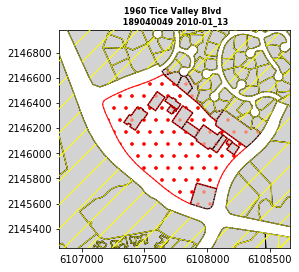

In [206]:
def map_parcels(
    parcel_gdf, id_field='APN', focus_id='178071017', subfocus_ids='',
    buff = 200, focus_buff = 500
):

    if type(focus_id)==str:
        focus_id = [focus_id]
    
    if type(subfocus_ids)!=list:
        subfocus_ids = [c for c in subfocus_ids]
        
    #if len(subfocus_ids)==0:
    #    subfocus_ids = list(subfocus_ids)
    
    focus_gdf = parcel_gdf[parcel_gdf[id_field].isin(focus_id)].copy()
    subfocus_gdf = parcel_gdf[parcel_gdf[id_field].isin(subfocus_ids)].copy()
    
    if len(focus_gdf)==0:
        print('ID not in parcels')

        return
    
    focus_bound = focus_gdf.unary_union
    minx,miny,maxx,maxy = focus_bound.buffer(buff+100).bounds
    #print(minx,miny,maxx,maxy)
    
    not_in_apn = (~parcel_gdf[id_field].isin(focus_id+subfocus_ids))
    near_gdf = parcel_gdf[
        not_in_apn&(parcel_gdf['geometry'].intersects(focus_bound.buffer(buff+focus_buff+1000)))
    ].copy()
    
    if 'Min Date' in list(focus_gdf):
        focus_date = focus_gdf['Min Date'].min()
        
        above_gdf = near_gdf[(near_gdf['Min Date']>focus_date)].copy()
        below_gdf = near_gdf[(near_gdf['Min Date']<=focus_date)].copy()

        ax = below_gdf.plot(ec='black', color='lightgrey', zorder=2)
        below_gdf[below_gdf['Min Date']!='2010-01'].plot(ax=ax, ec='black', color='grey', zorder=3)
        below_gdf.plot(ax=ax, ec='black', color='None', ls=('dotted'), zorder=8)
        above_gdf.plot(ax=ax, ec='Yellow', color='None', hatch="/", lw=0.5, zorder=9)
        
    else:
        ax = near_gdf.plot(ec='black', color='lightgrey', zorder=2)

    focus_gdf.plot(ax=ax, color='None',hatch=".", ec='Red', zorder=6)
    
    subfocus_gdf.plot(ax=ax, color='None',hatch=".", ec='salmon', lw=1.5, ls=('dotted'), zorder=5)

    #shared.plot(facecolor="#DDDDDD", hatch="//", zorder=4)

    #Parcel[Parcel['ID']=='Null Test'].plot(ax=ax, color='lightgrey', ec='None', zorder=3)
    
    if 'Cluster' in list(focus_gdf):
        #print(focus_id, focus_gdf['Address'].to_list()[0])
        #print('\n', )
        
        add = ' '.join([s.capitalize() for s in focus_gdf['Address'].to_list()[0].split()])
        txt1 = "{} \n {} {}".format(add, focus_id[0], focus_gdf['Cluster'].to_list()[0])
        #txt2 = "{} {}".format(focus_id)
        
        ax.set_title(txt1, fontsize=8, weight='bold',
                #horizontalalignment='left', verticalalignment='baseline'
                    )

    ax.set_xlim(minx-focus_buff, maxx+focus_buff)
    ax.set_ylim(miny-focus_buff, maxy+focus_buff)

    
import random
good_date = (~APG['Min Date'].isin(['2010-01', '2018-09']))
in_city = (APG['City']=='Walnut Creek')
xxx = (APG['APN'].str.contains('XXX'))
other = xxx

find_apn_list = [str(a) for a in APG[in_city&other]['APN'].to_list()]

apn_list = ['189040049']
#apn_list = [find_apn_list[idx] for idx in [random.randrange(0, len(find_apn_list)-1) for r in range(10)]]

for idx in apn_list:
    focus_apn = str(idx)
    
    cluster = APG[APG['APN']==focus_apn]['APN List'].to_list()
    if len(cluster)>0:
        cluster = [str(c) for c in list(cluster[0])]
    else:
        cluster = []
    
    cluster = list(new_parcels['APN'].unique())
    
    map_parcels(
        APG, id_field='APN', focus_id=focus_apn, subfocus_ids=cluster,
        buff = 200, focus_buff = 50
    )

In [123]:
pcmax = APG.loc[APG['City']=='Walnut Creek', 'Prior Cluster'].apply(len).max()
print(pcmax)
APG[APG['Prior Cluster'].apply(len)==pcmax] #['Cluster IDs'].to_list()

focus_apn = '189040049'
focus_parcel = APG[(APG['City']=='Walnut Creek')&(APG['APN']==focus_apn)]
post_APNs = focus_parcel['Post APNs'].to_list()[0][0]

new_parcels = APG[APG['Prior APNs'].apply(lambda apn: True if len([aa for aa in apn if focus_apn in aa])>0 else False)]

new_parcels['APN'].unique()

5


IndexError: list index out of range

remove = []
for fdate, fdict in gdf_dict.items():
    if fdate not in shp_dict.keys():
        remove.append(fdate)
        print(fdate, ' removed')
        break
    
    gdf = fdict['gdf']
    def get_main_geom_type(geom_type_list):
        gcount = get_dict_count(geom_type_list)
        import operator
        return max(gcount.items(), key=operator.itemgetter(1))[0]
    
    main_geom_type = get_main_geom_type(gdf['geometry'].geom_type.values)
    
    gdf_dict[fdate]['geom_type'] = main_geom_type
    
    check_dict = shp_dict[fdate]
    parcel = gdf.copy()
    good = False
    while good==False:
        if main_geom_type == 'Point':
            for shape, shapepath in check_dict.items():
                if 'parcel_py' in shape.lower():
                    #print('sjoined')

                    #polys = gpd.read_file(shapepath)
                    #parcel = gpd.sjoin(polys, parcel, lsuffix='_ppy')
                    remove.append(fdate)
                    
                    good = True
                    break
            break
        else:
            good=True
    if good==False:
        print(fdate, ' is a Point file but the parcel_py polys cant be found')
        remove.append(fdate)
remove = P.loc[P['Crs'].isna(), 'Date'].values
remove = P.loc[P['Filepath'].str.lower().str.contains('apn_pt'), 'Date'].values
for r in remove:
    gdf_dict.pop(r)